<a href="https://colab.research.google.com/github/ihagoSantos/special-topics-in-machine-learning/blob/main/03_ranknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Learning to Rank**

Técnica de ML usada para resolução de problemas de classificação. Uma das principais aplicações é em sistemas de busca (para e-commerce por exemplo), em que o objetivo é obter uma lista de itens claasificada, onde a ordem é importante.  

Em um sistema de busca, é importante que os resultados sejam ranqueados por relevância.

RankNet é um algoritmo de Learning to Rank desenvolvido em 2005 por Chris Burges da Microsoft Research. O algoritmo pode ser implementado usando um rede neural que analisa pares de objetos. Sua função de custo tem como objetivo minimizar o número de trocas necessárias para melhorar uma ordenação incorreta na classificação de uma par de resultados.



**RankNet**

In [1]:
import numpy as np

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Input, Lambda, Dropout, Subtract
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
%pylab inline

INPUT_DIM = 1536

Populating the interactive namespace from numpy and matplotlib


**Rede Base**

A rede siamesa cria duas dessas redes base para itens de classificação mais alta e mais baixa, respectivamente.

Para saber mais sobre redes siamesas:

[Image similarity estimation using a Siamese Network with a triplet loss](https://keras.io/examples/vision/siamese_network/)

[Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

In [2]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(INPUT_DIM, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(1))
    return seq

**Arquitetura da rede siamesa**

São criadas duas instâncias da arquitetura base e a diferença entre suas saídas são calculadas no final.

A diferença será a entrada para uma função de classificação para o cálculo da loss.

In [3]:
def create_meta_network(input_dim, base_network):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    rel_score = base_network(input_a)
    irr_score = base_network(input_b)

    # subtract scores
    diff = Subtract()([rel_score, irr_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid")(diff)

    # Build model.
    model = Model(inputs = [input_a, input_b], outputs = prob)
    model.compile(optimizer = "adam", loss = "binary_crossentropy")

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1536)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1536)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1)         │  2,461,313 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ subtract[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,461,313 (9.39 MB)

 Trainable params: 2,461,313 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

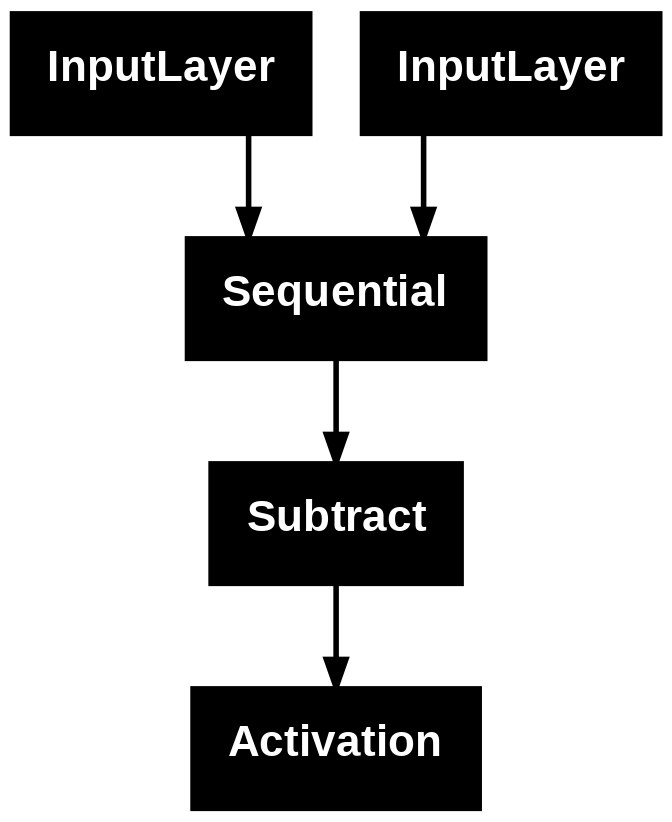

In [4]:
base_network = create_base_network(INPUT_DIM)
model = create_meta_network(INPUT_DIM, base_network)
model.summary()

plot_model(base_network, to_file='base.png')
plot_model(model, to_file='meta.png')

**Dataset sintético**

O dataset será composto por dois conjuntos de dimensão "N" gerados aleatoriamente.

In [5]:
# Fake data.
N = 1000
SPLIT=750
X_1 = 2* np.random.randn(N, INPUT_DIM) # notice this data is shifted by 2
X_2 = np.random.randn(N, INPUT_DIM)

X_1_train = X_1[0:SPLIT,:]
X_1_test = X_1[SPLIT:N,:]

X_2_train = X_2[0:SPLIT,:]
X_2_test =  X_2[SPLIT:N,:]


y = np.ones((X_1.shape[0], 1))

y_train = y[0:SPLIT,:]
y_test = y[SPLIT:N,:]

np.mean(X_1_train), np.mean(X_2_train)

(np.float64(-0.0039597043203795845), np.float64(0.0010213370548403874))

In [6]:
# Train model.

es=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

NUM_EPOCHS = 10
BATCH_SIZE = 10
history = model.fit([X_1_train, X_2_train], y_train,
                    validation_data=([X_1_test, X_2_test], y_test),
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1, callbacks=[es])

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1356 - val_loss: 1.6886e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 2.5591e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 2.5720e-04
Epoch 3: early stopping


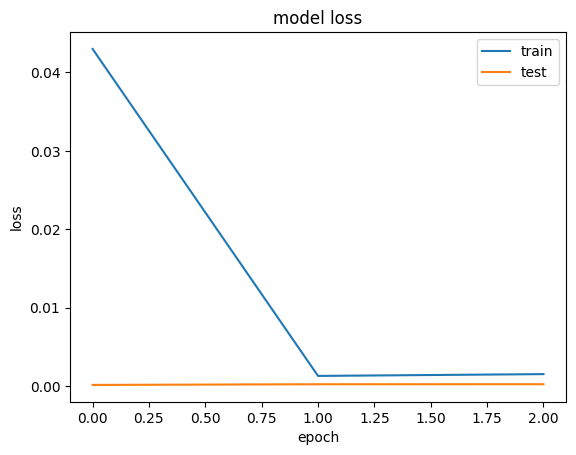

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [8]:
#the mean score of the high-rank distribution should be higher
np.mean(base_network.predict(X_1_test)), np.mean(base_network.predict(X_2_test))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


(np.float32(39.21983), np.float32(19.880709))

In [9]:
#AUC
(np.sum(base_network.predict(X_1_test) > base_network.predict(X_2_test))+0.0) / X_1_test.shape[0]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


np.float64(1.0)

In [10]:
np.sum(base_network.predict(X_1_test) > base_network.predict(X_2_test))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


np.int64(250)

**Referência**

[Learning to Rank from Pair-wise data](https://github.com/eggie5/RankNet)

[Learning to Rank using Gradient Descent](https://icml.cc/2015/wp-content/uploads/2015/06/icml_ranking.pdf)
